# references:
https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

In [42]:
# import required libraries
#!conda install nltk
import numpy as np
import pandas as pd
import nltk
import re
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
#nltk.download('punkt')

In [43]:
with open('pride_and_prejudice.txt','r') as f:
#with open('Pride and Prejudice.txt','r') as f:
    full_txt = f.read().strip('\n').replace("\''","'")
    # clean the unnecessary txt
    full_txt = full_txt.replace('_','').replace('make by 拉米网（www.lami.fun）','') 

In [44]:
#!pip install wordcloud

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

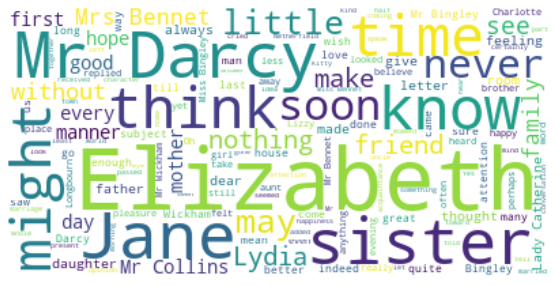

In [63]:
from wordcloud import WordCloud,STOPWORDS
sw = list(STOPWORDS)  + [
    "will","must","said","much","well", "one", "now", 'though','say','two'
]

wordcloud = WordCloud(background_color = 'white',stopwords=sw).generate(full_txt)
%pylab inline
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Partition (chapters/paragraphs/sentences)

In [4]:
# chapter-wise
chapter_txt = full_txt.split('Chapter ')[1:] #len(chapter_txt)=61
cleaned_chapter = []
for chapter in chapter_txt:
    cleaned_chapter.append(chapter[1:].replace('\n',''))
len(cleaned_chapter)

61

In [5]:
# paragraph-wise
cleaned_paragraph = []
for chapter in chapter_txt:
    para = [i for i in chapter.split('\n') if i != ""]
    cleaned_paragraph = cleaned_paragraph + para[1:]
len(cleaned_paragraph)

2063

In [6]:
# sentence-wise
cleaned_sentence = []
from nltk.tokenize import sent_tokenize
cleaned_sentence = [sent_tokenize(chapter) for chapter in cleaned_chapter]
cleaned_sentence = [x for y in cleaned_sentence for x in y]
len(cleaned_sentence)

5584

In [7]:
from nltk.tokenize import sent_tokenize
total_sentences = [sent_tokenize(chapter) for chapter in cleaned_chapter]
#cleaned_sentence = [x for y in cleaned_sentence for x in y]
sentencesPerChap = [len(sentences) for sentences in total_sentences]
split_point = [0]
for i in range(len(total_sentences)):
    split_point.append(split_point[i]+sentencesPerChap[i])

In [92]:
CHARACTER_LIST = [
    'Mr. Darcy', 'Mr. Bingley','Elizabeth','Miss Bingley','Lydia','Catherine', # 0 ~ 5
    'Mary','Georgiana','Collins','Charlotte','Mr. Wickham',         #6 ~ 10
    'Miss de Bourgh','Mr. Bennet','Mrs. Bennet','Jane','Louisa',    #11 ~ 15
    'Mr. Hurst','Lucases','Miss Lucas','Sir William','Mrs. Gardiner',  # 16 ~20
    'Mr. Gardiner','Mr. Phillips','Mrs. Phillips','Fitzwilliam','Colonel Forster', #21~25
    'Mrs. Forster','Mr. Jones','Lady Catherine'   #26～28
]

NICKNAME_LIST = [
    'Lizzy','Kitty','Miss Lucas','Caroline','Miss Darcy','Lady Lucas','Mrs. Hurst','Charles','Darcy','Bingley'
]

MATCH = [(2,0),(5,1),(9,2),(3,3),(6,4),(8,5),(14,6),(1,7),(0,8),(1,9)]
                                        
num_people = len(CHARACTER_LIST)                                    

In [93]:
def name_plus_nick(list_1,list_2):
    co_list = []
    len_1 = len(list_1)
    for i in range(len_1):
        if list_1[i]+list_2[i] == 0:
            co_list.append(0)
        else:
            co_list.append(1)
    return co_list

In [94]:
def find_interaction(sections):
    Characters = {}
    occurrence = []
    occurrence_2 = []
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence.append(np.array(vector))
        Characters[person] = np.array(vector)
    
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence_2.append(np.array(vector))
    
    for match in MATCH:
        name = match[0]
        nick = match[1]
        occur_new = name_plus_nick(occurrence[name],occurrence_2[nick])
        occurrence[name] = occur_new
        person = CHARACTER_LIST[name]
        Characters[person] = occur_new

    occurrence_matrix = pd.DataFrame(occurrence) # num of people * num of sections 15*61
    co_occur = pd.DataFrame(np.dot(occurrence_matrix,occurrence_matrix.T))
    np.fill_diagonal(co_occur.values, 0)
    co_occur = co_occur / np.linalg.norm(co_occur, ord = 1, axis = 0)
    return co_occur, occurrence_matrix, Characters

In [95]:
def text_rank(section_name, section):
    co_occur, occurrence, Characters = find_interaction(section)
    #print(co_occur)
    P = co_occur
    alpha = 0.85
    P = alpha* co_occur + (1-alpha)*np.ones((num_people,num_people))/num_people
    # interation PageRank
    rank_inter = np.ones((num_people, 1))/num_people
    for i in range(100000):
        rank_inter = np.dot(P,rank_inter)
    rank_inter = rank_inter.reshape(-1,)
    
    text_rank = rank_inter[np.argsort(rank_inter)[::-1]].tolist()
    text_chara = [CHARACTER_LIST[i] for i in np.argsort(rank_inter)[::-1].tolist()]
    Characters_sort = sorted(Characters.items(), key=lambda x: sum(x[1]), reverse = True)
    occur_rank = [sum(character[1]) for character in Characters_sort]
    occur_chara = [character[0] for character in Characters_sort]
  
    rank_table = pd.DataFrame([text_chara, occur_chara]).T
    rank_table.columns = ['TextRank','Occurrence Rank']
    rank_table.index = np.arange(1,num_people+1).tolist()
    print(rank_table)
    
    x = np.arange(len(CHARACTER_LIST)).tolist()
    plt.figure(figsize=(15,5))
    plt.bar(x, text_rank)
    plt.xticks(x, text_chara, rotation=45)
    plt.title(f'PageRank by {section_name} (Descending)')
    
    plt.show()
    return occurrence, co_occur

           TextRank  Occurrence Rank
1         Charlotte        Elizabeth
2         Elizabeth        Charlotte
3         Mr. Darcy        Mr. Darcy
4              Jane             Jane
5       Mr. Bingley      Mr. Bingley
6         Catherine        Catherine
7       Mrs. Bennet      Mrs. Bennet
8           Collins          Collins
9              Mary             Mary
10            Lydia            Lydia
11       Mr. Bennet       Mr. Bennet
12   Lady Catherine   Lady Catherine
13     Miss Bingley     Miss Bingley
14      Mr. Wickham      Mr. Wickham
15      Sir William      Sir William
16    Mrs. Gardiner    Mrs. Gardiner
17   Miss de Bourgh   Miss de Bourgh
18       Miss Lucas     Mr. Gardiner
19  Colonel Forster          Lucases
20     Mr. Gardiner       Miss Lucas
21          Lucases  Colonel Forster
22    Mrs. Phillips      Fitzwilliam
23      Fitzwilliam        Georgiana
24        Georgiana    Mrs. Phillips
25        Mr. Hurst        Mr. Hurst
26     Mrs. Forster           Louisa
2

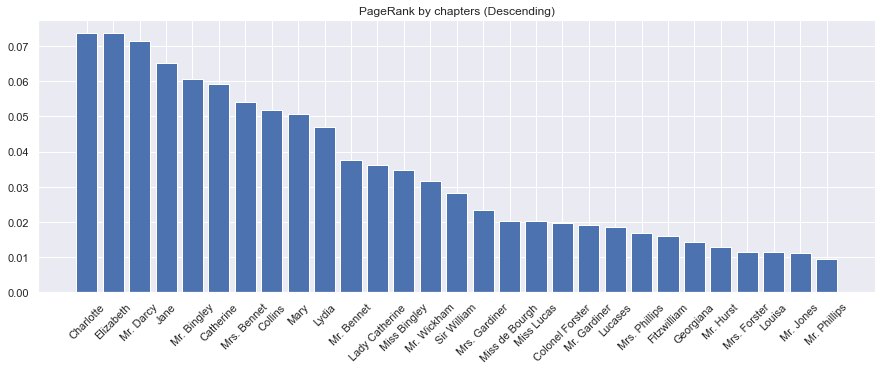

,Id,Label,Weight
0,Mr. Darcy,Mr. Darcy,57
1,Mr. Bingley,Mr. Bingley,48
2,Elizabeth,Elizabeth,60
3,Miss Bingley,Miss Bingley,24
4,Lydia,Lydia,33
5,Catherine,Catherine,46
6,Mary,Mary,36
7,Georgiana,Georgiana,8
8,Collins,Collins,38
9,Charlotte,Charlotte,60


In [96]:
occur_chapter, co_occur_chapter = text_rank('chapters', cleaned_chapter)

co_occur_chapter.index = CHARACTER_LIST
co_occur_chapter.columns = CHARACTER_LIST
relationship_chapter = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        relationship_chapter.append(co_occur_chapter.loc[name_1,name_2])

source = [val for val in CHARACTER_LIST for i in range(len(CHARACTER_LIST))]
target = CHARACTER_LIST * len(CHARACTER_LIST)
edge_chapter = pd.DataFrame([source,target,relationship_chapter]).T
edge_chapter.columns = ['Source', 'Target', 'Weight']
edge_chapter.to_csv('edge_chapter.csv', index = False)

occur_chapter.index = CHARACTER_LIST
times_chapter = occur_chapter.sum(axis = 1)
node_chapter = pd.DataFrame([times_chapter.index,times_chapter.index,times_chapter]).T
node_chapter.columns = ['Id','Label','Weight']
node_chapter.to_csv('node_chapter.csv', index = False)
node_chapter

           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Charlotte        Charlotte
3         Mr. Darcy        Mr. Darcy
4           Collins             Jane
5         Catherine          Collins
6       Mr. Bingley        Catherine
7              Jane      Mr. Bingley
8              Mary             Mary
9             Lydia            Lydia
10   Lady Catherine      Mrs. Bennet
11      Mrs. Bennet   Lady Catherine
12     Miss Bingley       Mr. Bennet
13       Mr. Bennet     Miss Bingley
14      Mr. Wickham      Mr. Wickham
15      Sir William    Mrs. Gardiner
16    Mrs. Gardiner      Sir William
17       Miss Lucas      Fitzwilliam
18      Fitzwilliam     Mr. Gardiner
19     Mr. Gardiner       Miss Lucas
20    Mrs. Phillips  Colonel Forster
21   Miss de Bourgh   Miss de Bourgh
22  Colonel Forster    Mrs. Phillips
23          Lucases          Lucases
24        Georgiana        Georgiana
25        Mr. Hurst        Mr. Hurst
26     Mrs. Forster     Mrs. Forster
2

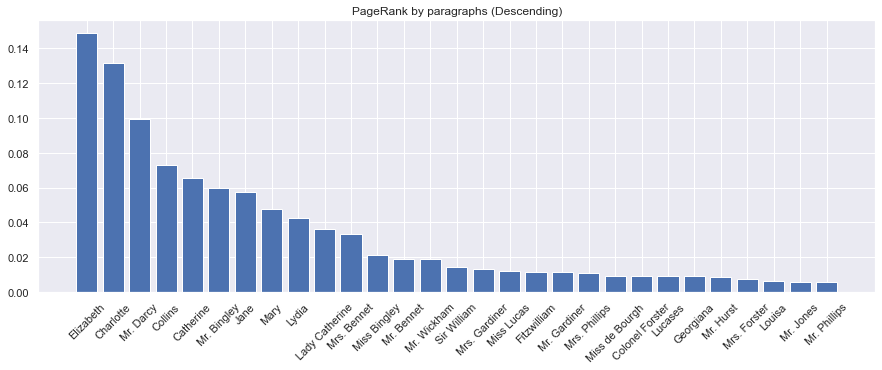

,Id,Label,Weight
0,Mr. Darcy,Mr. Darcy,365
1,Mr. Bingley,Mr. Bingley,178
2,Elizabeth,Elizabeth,679
3,Miss Bingley,Miss Bingley,79
4,Lydia,Lydia,137
5,Catherine,Catherine,203
6,Mary,Mary,161
7,Georgiana,Georgiana,12
8,Collins,Collins,217
9,Charlotte,Charlotte,577


In [97]:
occur_paragraph, co_occur_paragraph = text_rank('paragraphs', cleaned_paragraph)

co_occur_paragraph.index = CHARACTER_LIST
co_occur_paragraph.columns = CHARACTER_LIST
relationship_paragraph = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        relationship_paragraph.append(co_occur_paragraph.loc[name_1,name_2])

source = [val for val in CHARACTER_LIST for i in range(len(CHARACTER_LIST))]
target = CHARACTER_LIST * len(CHARACTER_LIST)
edge_paragraph = pd.DataFrame([source,target,relationship_paragraph]).T
edge_paragraph.columns = ['Source', 'Target', 'Weight']
edge_paragraph.to_csv('edge_paragraph.csv', index = False)

occur_paragraph.index = CHARACTER_LIST
times_paragraph = occur_paragraph.sum(axis = 1)
node_paragraph = pd.DataFrame([times_paragraph.index,times_paragraph.index,times_paragraph]).T
node_paragraph.columns = ['Id','Label','Weight']
node_paragraph.to_csv('node_paragraph.csv', index = False)
node_paragraph

           TextRank  Occurrence Rank
1         Elizabeth        Elizabeth
2         Charlotte        Charlotte
3         Mr. Darcy        Mr. Darcy
4           Collins             Jane
5         Catherine          Collins
6       Mr. Bingley        Catherine
7              Mary      Mr. Bingley
8              Jane             Mary
9             Lydia            Lydia
10   Lady Catherine      Mrs. Bennet
11      Mrs. Bennet   Lady Catherine
12     Miss Bingley     Miss Bingley
13      Mr. Wickham       Mr. Bennet
14       Mr. Bennet      Mr. Wickham
15      Sir William      Sir William
16       Miss Lucas    Mrs. Gardiner
17        Georgiana      Fitzwilliam
18    Mrs. Gardiner     Mr. Gardiner
19   Miss de Bourgh  Colonel Forster
20     Mr. Gardiner       Miss Lucas
21      Fitzwilliam   Miss de Bourgh
22    Mrs. Phillips    Mrs. Phillips
23          Lucases        Georgiana
24  Colonel Forster          Lucases
25     Mrs. Forster        Mr. Hurst
26        Mr. Hurst     Mrs. Forster
2

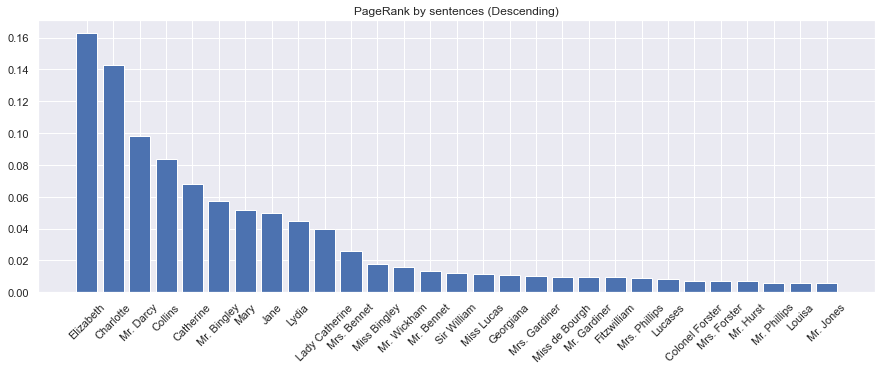

,Id,Label,Weight
0,Mr. Darcy,Mr. Darcy,396
1,Mr. Bingley,Mr. Bingley,199
2,Elizabeth,Elizabeth,786
3,Miss Bingley,Miss Bingley,84
4,Lydia,Lydia,160
5,Catherine,Catherine,222
6,Mary,Mary,193
7,Georgiana,Georgiana,14
8,Collins,Collins,273
9,Charlotte,Charlotte,667


In [98]:
occur_sentence, co_occur_sentence = text_rank('sentences', cleaned_sentence)

co_occur_sentence.index = CHARACTER_LIST
co_occur_sentence.columns = CHARACTER_LIST
relationship_sentence = []

# Bingley视角出发对Darcy的weight 
for name_1 in CHARACTER_LIST:
    for name_2 in CHARACTER_LIST:
        relationship_sentence.append(co_occur_sentence.loc[name_1,name_2])

source = [val for val in CHARACTER_LIST for i in range(len(CHARACTER_LIST))]
target = CHARACTER_LIST * len(CHARACTER_LIST)
edge_sentence = pd.DataFrame([source,target,relationship_sentence]).T
edge_sentence.columns = ['Source', 'Target', 'Weight']
edge_sentence.to_csv('edge_sentence.csv', index = False)

occur_sentence.index = CHARACTER_LIST
times_sentence = occur_sentence.sum(axis = 1)
node_sentence = pd.DataFrame([times_sentence.index,times_sentence.index,times_sentence]).T
node_sentence.columns = ['Id','Label','Weight']
node_sentence.to_csv('node_sentence.csv', index = False)
node_sentence

## Sentiment Analysis
http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [99]:
#!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook as tqdm

In [100]:
analyzer = SentimentIntensityAnalyzer()
chaper_wise_sentiment = []
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    chaper_wise_sentiment.append(sentiments)

  0%|          | 0/61 [00:00<?, ?it/s]

In [101]:
SENTIMENTS = ['compound', 'neg', 'neu', 'pos']
y = [[sentiments['compound'] for sentiments in chaper_wise_sentiment],
     [sentiments['neg'] for sentiments in chaper_wise_sentiment],
     [sentiments['neu'] for sentiments in chaper_wise_sentiment],
     [sentiments['pos'] for sentiments in chaper_wise_sentiment]
    ]

In [102]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

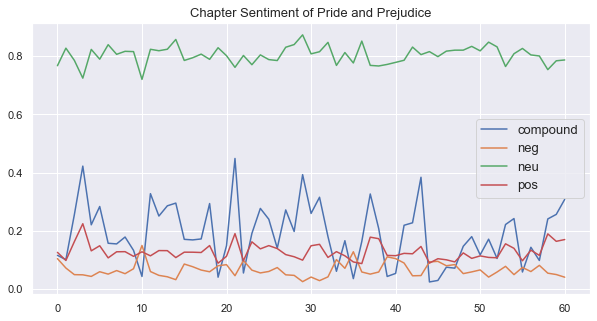

In [116]:
plt.figure(figsize=(10,5))
for i in range(len(SENTIMENTS)):
    plt.plot(y[i],label=SENTIMENTS[i])
    plt.legend(loc='best', fontsize=13)
    #plt.plot(movingaverage(y[i], 4), color='k', linewidth=1, linestyle=':', label = 'Moving Average')

plt.title('Chapter Sentiment of Pride and Prejudice', fontsize=13)
plt.show()

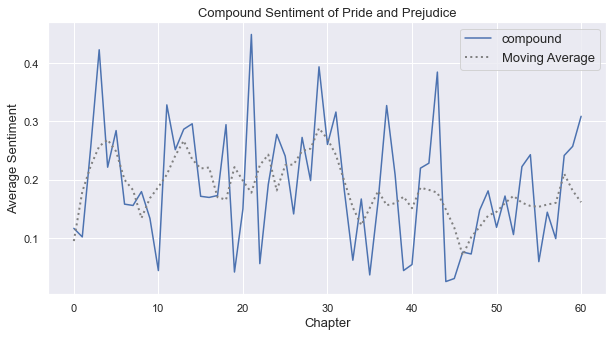

In [132]:
plt.figure(figsize=(10,5))
plt.plot(y[0],label=SENTIMENTS[0])
plt.plot(movingaverage(y[0], 5), color='grey', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Compound Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)
plt.show()

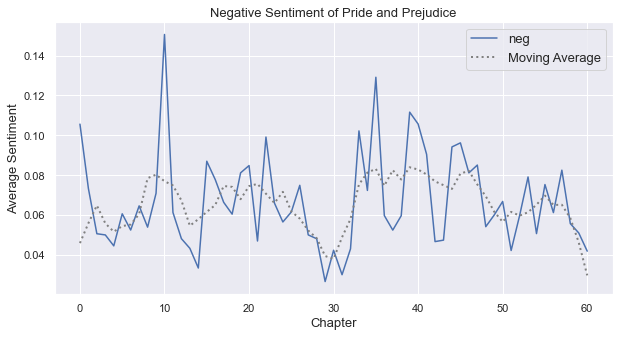

In [133]:
plt.figure(figsize=(10,5))
plt.plot(y[1],label=SENTIMENTS[1])
plt.plot(movingaverage(y[1], 5), color='grey', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Negative Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)
plt.show()

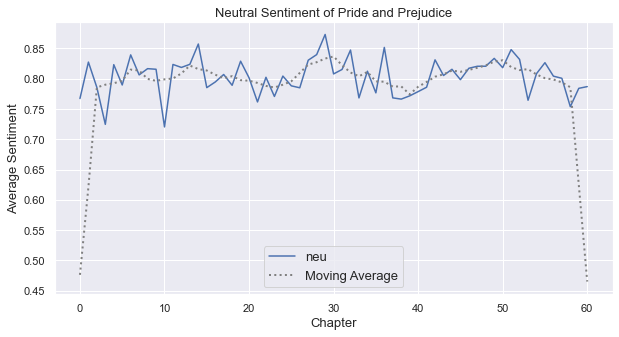

In [134]:
plt.figure(figsize=(10,5))
plt.plot(y[2],label=SENTIMENTS[2])
plt.plot(movingaverage(y[2], 5),  color='grey', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Neutral Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)
plt.show()

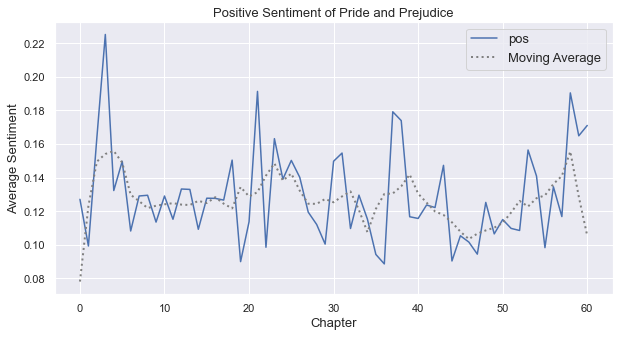

In [135]:
plt.figure(figsize=(10,5))
plt.plot(y[3],label=SENTIMENTS[3])
plt.plot(movingaverage(y[3], 5), color='grey', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=13)
plt.title('Positive Sentiment of Pride and Prejudice', fontsize=13)
plt.xlabel('Chapter', fontsize=13)
plt.ylabel('Average Sentiment', fontsize=13)
plt.show()

---

In [110]:
analyzer_2 = SentimentIntensityAnalyzer()
sentiments = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'].append(vs['compound'])
        sentiments['neg'].append(vs['neg'])
        sentiments['neu'].append(vs['neu'])
        sentiments['pos'].append(vs['pos'])

  0%|          | 0/61 [00:00<?, ?it/s]

In [111]:
sentiment_matrix = pd.DataFrame(sentiments).T # sentiment * sentences
np.shape(sentiment_matrix)

(4, 5584)

In [49]:
#!pip install afinn
from afinn import Afinn
afinn = Afinn()
sentiment_scores = np.matrix([afinn.score(sentence) for sentence in cleaned_sentence]).T

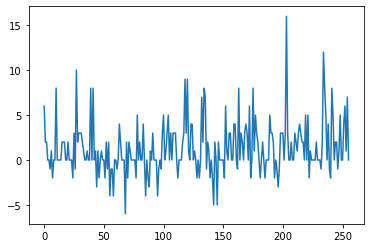

In [93]:
plt.plot(sentiment_scores[0:sum(sentencesPerChap[:4])])

In [55]:
np.shape(sentiment_scores)

(5976, 1)

In [53]:
np.shape(occur_sentence.T)

(5976, 14)

In [75]:
np.linspace(-2, 2, 5)

array([-2., -1.,  0.,  1.,  2.])

----


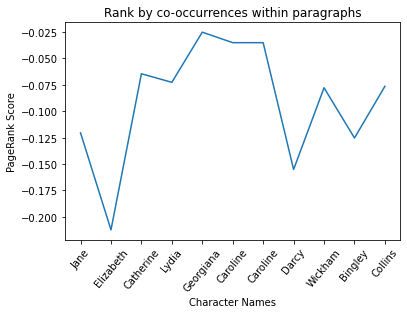

In [138]:
# Eigenvalue method
w,v = np.linalg.eig(P) #这里为啥用P就不对呢…… 奇了怪了 -P是对的？
x = np.arange(len(CHARACTER_LIST))
rank_eigen = v[:,0]/np.linalg.norm(v[:,0], ord = 1) 
plt.plot(x,rank_eigen)
plt.xticks(x, CHARACTER_LIST, rotation=50)
plt.xlabel('Character Names')
plt.ylabel('PageRank Score')
plt.title(f'Rank by co-occurrences within {section_name}')
plt.show()

## Named entity recognition (NER)
is probably the first step towards information extraction that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons,

In [ ]:
from __future__ import print_function
import nltk
print(nltk.__version__)

## Gephi 可视化


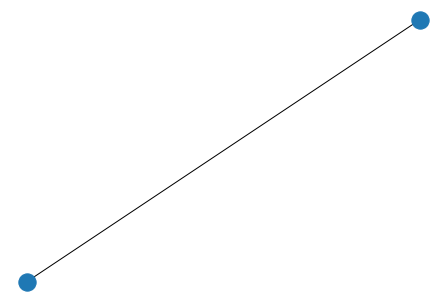

[1, 2]

In [11]:
import networkx as nx
G = nx.Graph() # 创建空图

G.add_node(1, time='5pm') # 添加节点，并赋节点属性
G.add_edge(1, 2, weight=4.7 ) # 添加边，并赋边属性

# 图显示需要借助matplotlib
import matplotlib.pyplot as plt

nx.draw(G) #绘制网络G
plt.show() # 在窗口中显示这幅图像
nx.write_gexf(G,'your_file_name.gexf') # 将图存为gexf文件，进而使用Gephi可视化


G._node # 节点及其属性的字典
G._adj # 节点及其邻居节点的字典
list(G.nodes()) # 节点列表

# 查找某一节点的邻居节点